# 1.30g: Lattice Space Analysis

**Purpose:** Transform dead token displacements into lattice coordinates where quantization structure becomes explicit.

## The Transformation

Given:
- `W[t, i, n]` — position of token i, dimension n, at time t (in bfloat16)
- `U[t, i, n]` — ULP (Unit in Last Place) at position W[t, i, n] (in bfloat16)

Define:
- `ΔW[τ, i, n] = (W[τ, i, n] - W[τ-1, i, n]) / U[τ-1, i, n]`

**Interpretation:** ΔW[τ, i, n] tells us: "Starting from position W[τ-1, i, n], how many lattice steps did dimension n take?"

## Critical: Work in bfloat16

The embeddings are stored and updated in **bfloat16**. That's the actual quantization lattice. We must compute ULP in bfloat16, not convert to float32 first (which would give us wrong ULP values).

## What We Expect

- **Early training (large gradients):** ΔW >> 1 (many ULP per step)
- **Thermal regime:** ΔW ≈ 0.1 to 10 (sub-lattice to few-lattice motion)
- **Lattice regime:** ΔW ∈ {0, ±1, ±2, ...} (quantized hops)
- **Frozen regime:** ΔW = 0 exactly

## Focus

Dead tokens only — we're studying what happens to tokens that never get trained.

## Parameters

In [15]:
# Data path
DATA_PATH = "../tensors/Thimble/thimble_6.h5"

# Plot settings
DPI = 200
FIGSIZE = (12, 6)

# Analysis windows (timesteps)
EARLY_WINDOW = (0, 100)      # Thermal regime
MIDDLE_WINDOW = (400, 800)   # Transition to lattice
LATE_WINDOW = (1200, 1600)   # Lattice regime
FROZEN_WINDOW = (3292, 3500) # Permanent freeze

print("✓ Parameters set")

✓ Parameters set


## Imports

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import h5py
from pathlib import Path

print("✓ Imports complete")

✓ Imports complete


## Load Data (Keep in bfloat16!)

In [17]:
print(f"Loading dead token trajectories from {DATA_PATH}...\n")

with h5py.File(DATA_PATH, 'r') as f:
    # Load metadata
    n_steps = f.attrs['num_steps']
    dead_mask = torch.from_numpy(f['dead_mask'][:]).bool()
    n_dead = dead_mask.sum().item()
    
    # Load dead token trajectories as bfloat16
    print(f"Loading W[:, dead_mask, :] ... ({n_steps+1} × {n_dead} × 64)")
    W_dead = torch.from_numpy(f['W'][:, dead_mask, :]).to(torch.bfloat16)
    # DO NOT convert to float32 yet!

print(f"\n✓ Data loaded: {tuple(W_dead.shape)}")
print(f"Dtype: {W_dead.dtype}")
print(f"Dead tokens: {n_dead}")
print(f"\nMemory estimate: {W_dead.nbytes / 1e9:.2f} GB")

Loading dead token trajectories from ../tensors/Thimble/thimble_6.h5...

Loading W[:, dead_mask, :] ... (6001 × 3699 × 64)

✓ Data loaded: (6001, 3699, 64)
Dtype: torch.bfloat16
Dead tokens: 3699

Memory estimate: 2.84 GB


## Define ULP Computation

In [18]:
def compute_ulp(x):
    """
    Compute the ULP (Unit in Last Place) for each element in x.
    
    IMPORTANT: x should be in the dtype you want to compute ULP for.
    For bfloat16 analysis, pass bfloat16 tensors.
    
    For positive x: ULP = nextafter(x, x+1) - x
    For negative x: ULP = x - nextafter(x, x-1)
    
    Returns absolute value of ULP (always positive), same dtype as input.
    """
    # Handle positive values
    ulp_pos = torch.nextafter(x, x + torch.ones_like(x)) - x
    
    # Handle negative values
    ulp_neg = x - torch.nextafter(x, x - torch.ones_like(x))
    
    # Choose based on sign
    ulp = torch.where(x >= 0, ulp_pos, ulp_neg)
    
    return ulp.abs()

# Test on bfloat16 values
test_vals = torch.tensor([1.0, 0.5, 0.1, 0.01, -0.5], dtype=torch.bfloat16)
test_ulps = compute_ulp(test_vals)

print("Test ULP computation (bfloat16):")
for v, u in zip(test_vals, test_ulps):
    print(f"  x = {v.item():8.4f} → ULP = {u.item():.6e}")

print("\nExpected for bfloat16:")
print("  x = 1.0 → ULP ≈ 0.0078 (2^-7)")
print("  x = 0.5 → ULP ≈ 0.0039 (2^-8)")

print("\n✓ ULP function defined")

Test ULP computation (bfloat16):
  x =   1.0000 → ULP = 7.812500e-03
  x =   0.5000 → ULP = 3.906250e-03
  x =   0.1001 → ULP = 4.882812e-04
  x =   0.0100 → ULP = 6.103516e-05
  x =  -0.5000 → ULP = 3.906250e-03

Expected for bfloat16:
  x = 1.0 → ULP ≈ 0.0078 (2^-7)
  x = 0.5 → ULP ≈ 0.0039 (2^-8)

✓ ULP function defined


## Compute Lattice Displacements

In [19]:
print("Computing lattice-space displacements...\n")

# ULP at starting positions (where tokens start each step)
# Compute in bfloat16!
print("Computing ULP at starting positions (bfloat16)...")
U_start = compute_ulp(W_dead[:-1])  # (6000, 3699, 64) in bfloat16

# Displacement in physical space (bfloat16)
print("Computing displacements in physical space (bfloat16)...")
dW = W_dead[1:] - W_dead[:-1]  # (6000, 3699, 64) in bfloat16

# Transform to lattice space (displacement in ULP multiples)
print("Transforming to lattice space...")
dW_lattice_bf16 = dW / (U_start + 1e-30)  # bfloat16 / bfloat16

# Convert to float32 for analysis (higher precision stats)
print("Converting to float32 for analysis...")
dW_lattice = dW_lattice_bf16.float()

print(f"\nLattice displacements: {tuple(dW_lattice.shape)}")
print(f"Memory: {dW_lattice.nbytes / 1e9:.2f} GB")

# Sanity check: count exact zeros (frozen)
n_frozen_coords = (dW_lattice == 0).sum().item()
n_total_coords = dW_lattice.numel()
frozen_fraction = n_frozen_coords / n_total_coords

print(f"\nFrozen coordinates: {n_frozen_coords:,} / {n_total_coords:,} ({frozen_fraction:.1%})")
print(f"\n✓ Lattice transformation complete")

Computing lattice-space displacements...

Computing ULP at starting positions (bfloat16)...
Computing displacements in physical space (bfloat16)...
Transforming to lattice space...
Converting to float32 for analysis...

Lattice displacements: (6000, 3699, 64)
Memory: 5.68 GB

Frozen coordinates: 1,385,749,994 / 1,420,416,000 (97.6%)

✓ Lattice transformation complete


## Compute Per-Token Lattice Displacement Norms

In [20]:
print("Computing per-token displacement norms in lattice space...\n")

# L2 norm: Euclidean distance in lattice space
dW_lattice_L2 = torch.norm(dW_lattice, dim=2)  # (6000, 3699)

# L∞ norm: max coordinate change in lattice space
dW_lattice_Linf = dW_lattice.abs().max(dim=2)[0]  # (6000, 3699)

# L1 norm: sum of absolute coordinate changes
dW_lattice_L1 = dW_lattice.abs().sum(dim=2)  # (6000, 3699)

print(f"L2 norms: {tuple(dW_lattice_L2.shape)}")
print(f"L∞ norms: {tuple(dW_lattice_Linf.shape)}")
print(f"L1 norms: {tuple(dW_lattice_L1.shape)}")
print(f"\n✓ Norms computed")

Computing per-token displacement norms in lattice space...

L2 norms: (6000, 3699)
L∞ norms: (6000, 3699)
L1 norms: (6000, 3699)

✓ Norms computed


## Plot 1: Lattice Displacement Evolution Over Time

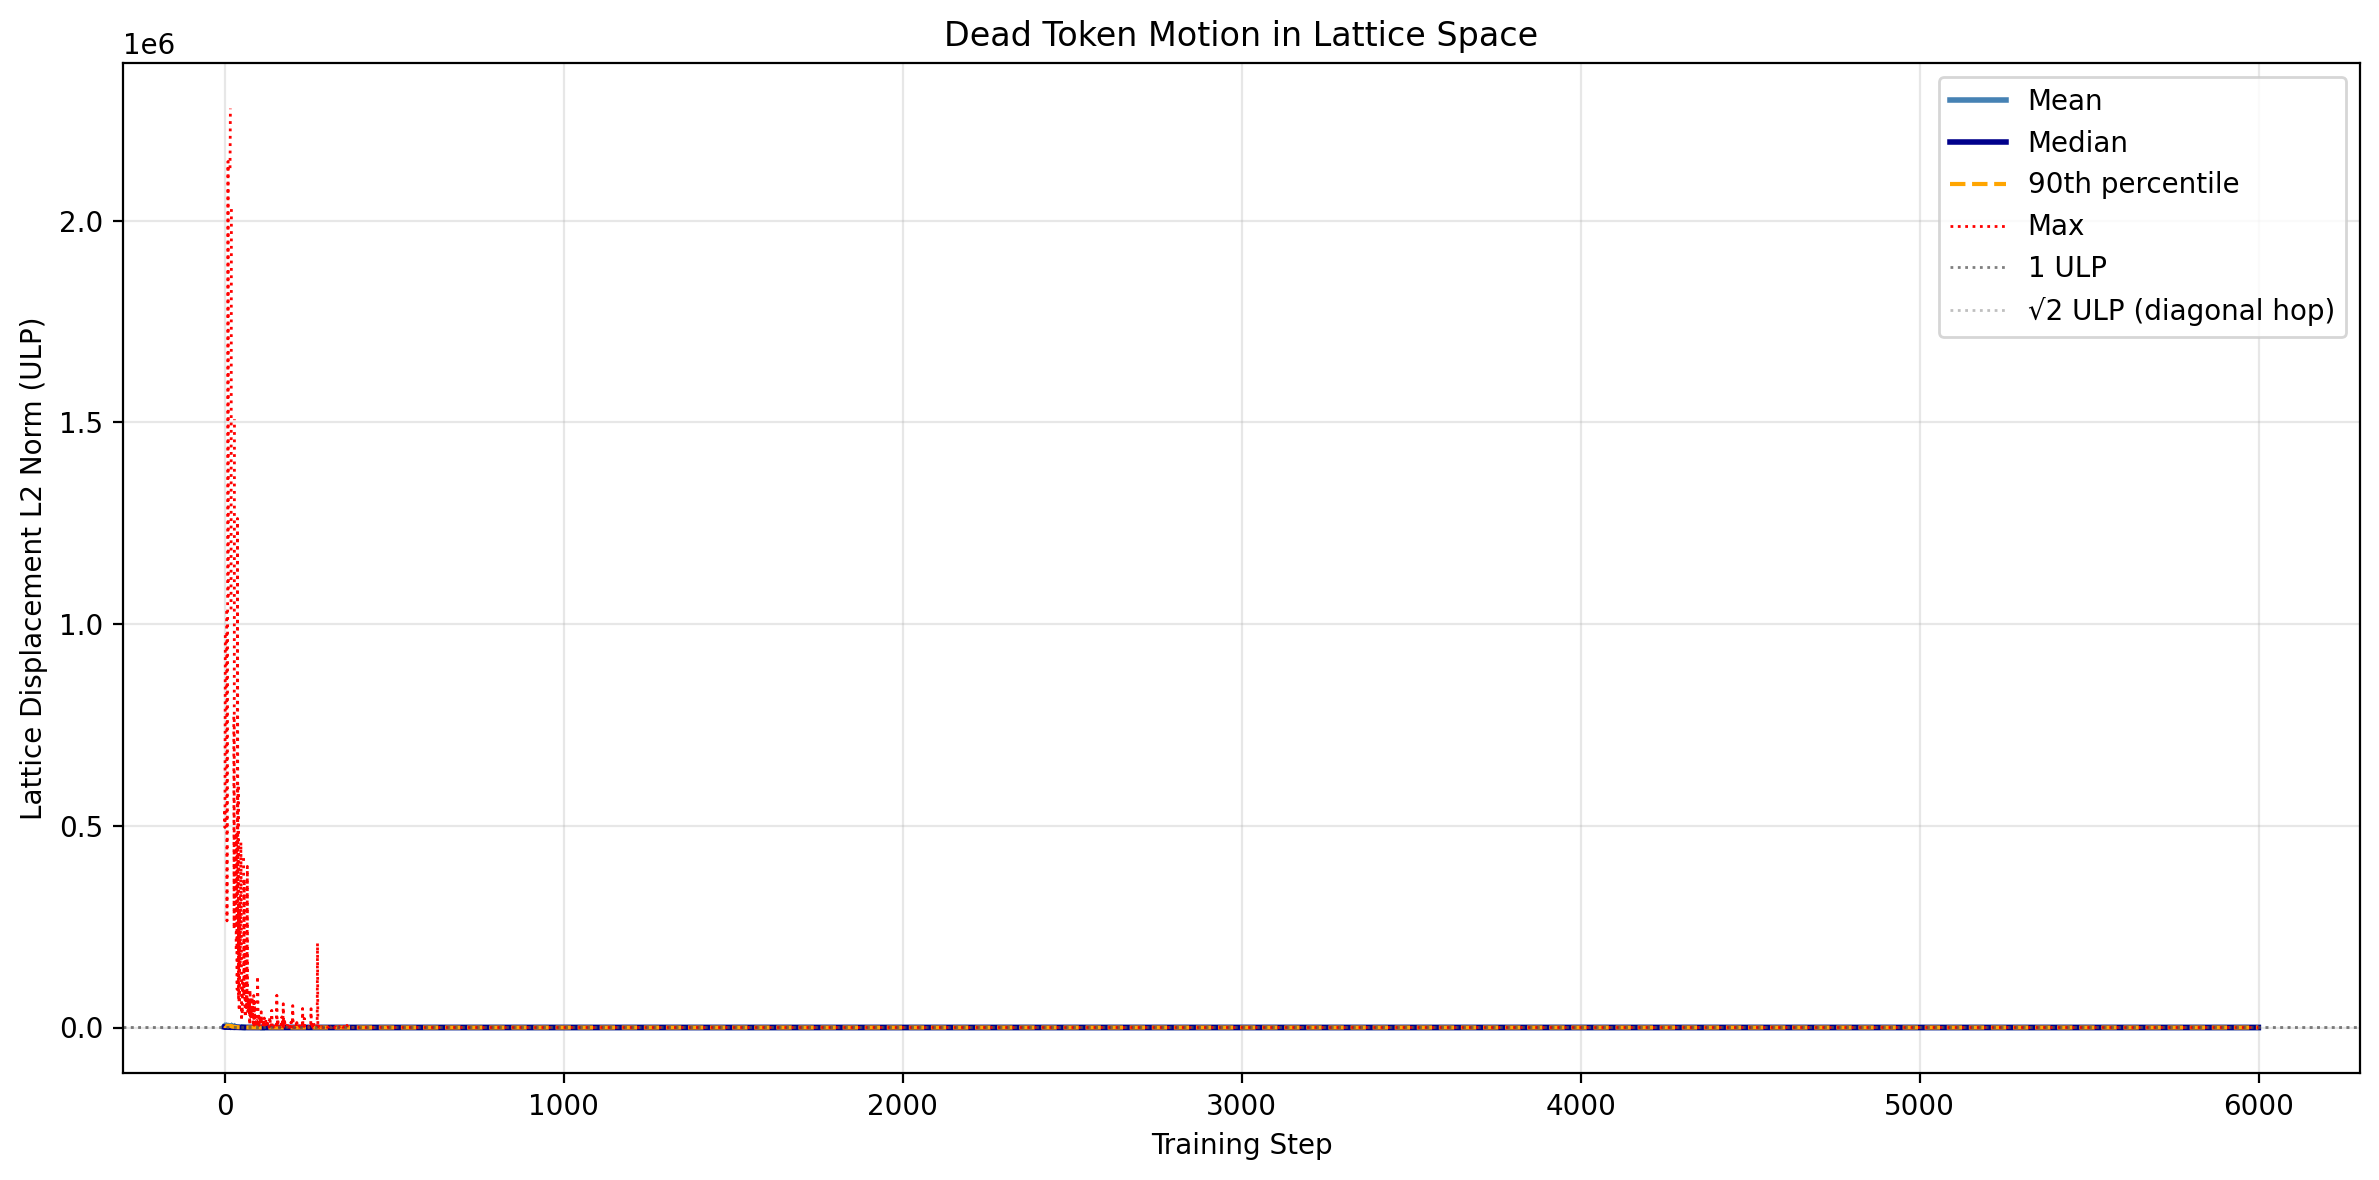


Interpretation: How many ULP does a typical token move per step?
  >> 1: Continuous motion (quantization irrelevant)
  ≈ 1-10: Lattice regime (hops dominate)
  << 1: Sub-lattice (trying to move but quantization prevents it)
  = 0: Frozen


In [26]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Mean, median, and percentiles of L2 norm in lattice space
mean_L2 = dW_lattice_L2.mean(dim=1).numpy()
median_L2 = dW_lattice_L2.median(dim=1)[0].numpy()
p90_L2 = dW_lattice_L2.quantile(0.9, dim=1).numpy()
max_L2 = dW_lattice_L2.max(dim=1)[0].numpy()

ax.plot(mean_L2, linewidth=2, color='steelblue', label='Mean')
ax.plot(median_L2, linewidth=2, color='darkblue', label='Median')
ax.plot(p90_L2, linewidth=1.5, linestyle='--', color='orange', label='90th percentile')
ax.plot(max_L2, linewidth=1, linestyle=':', color='red', label='Max')

ax.axhline(1, color='black', linestyle=':', linewidth=1, alpha=0.5, label='1 ULP')
ax.axhline(np.sqrt(2), color='gray', linestyle=':', linewidth=1, alpha=0.5, label='√2 ULP (diagonal hop)')

ax.set_xlabel('Training Step')
ax.set_ylabel('Lattice Displacement L2 Norm (ULP)')
ax.set_title('Dead Token Motion in Lattice Space')
ax.set_yscale('linear')
ax.legend()
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("\nInterpretation: How many ULP does a typical token move per step?")
print("  >> 1: Continuous motion (quantization irrelevant)")
print("  ≈ 1-10: Lattice regime (hops dominate)")
print("  << 1: Sub-lattice (trying to move but quantization prevents it)")
print("  = 0: Frozen")

## Plot 2: Histogram of Lattice Displacements in Time Windows

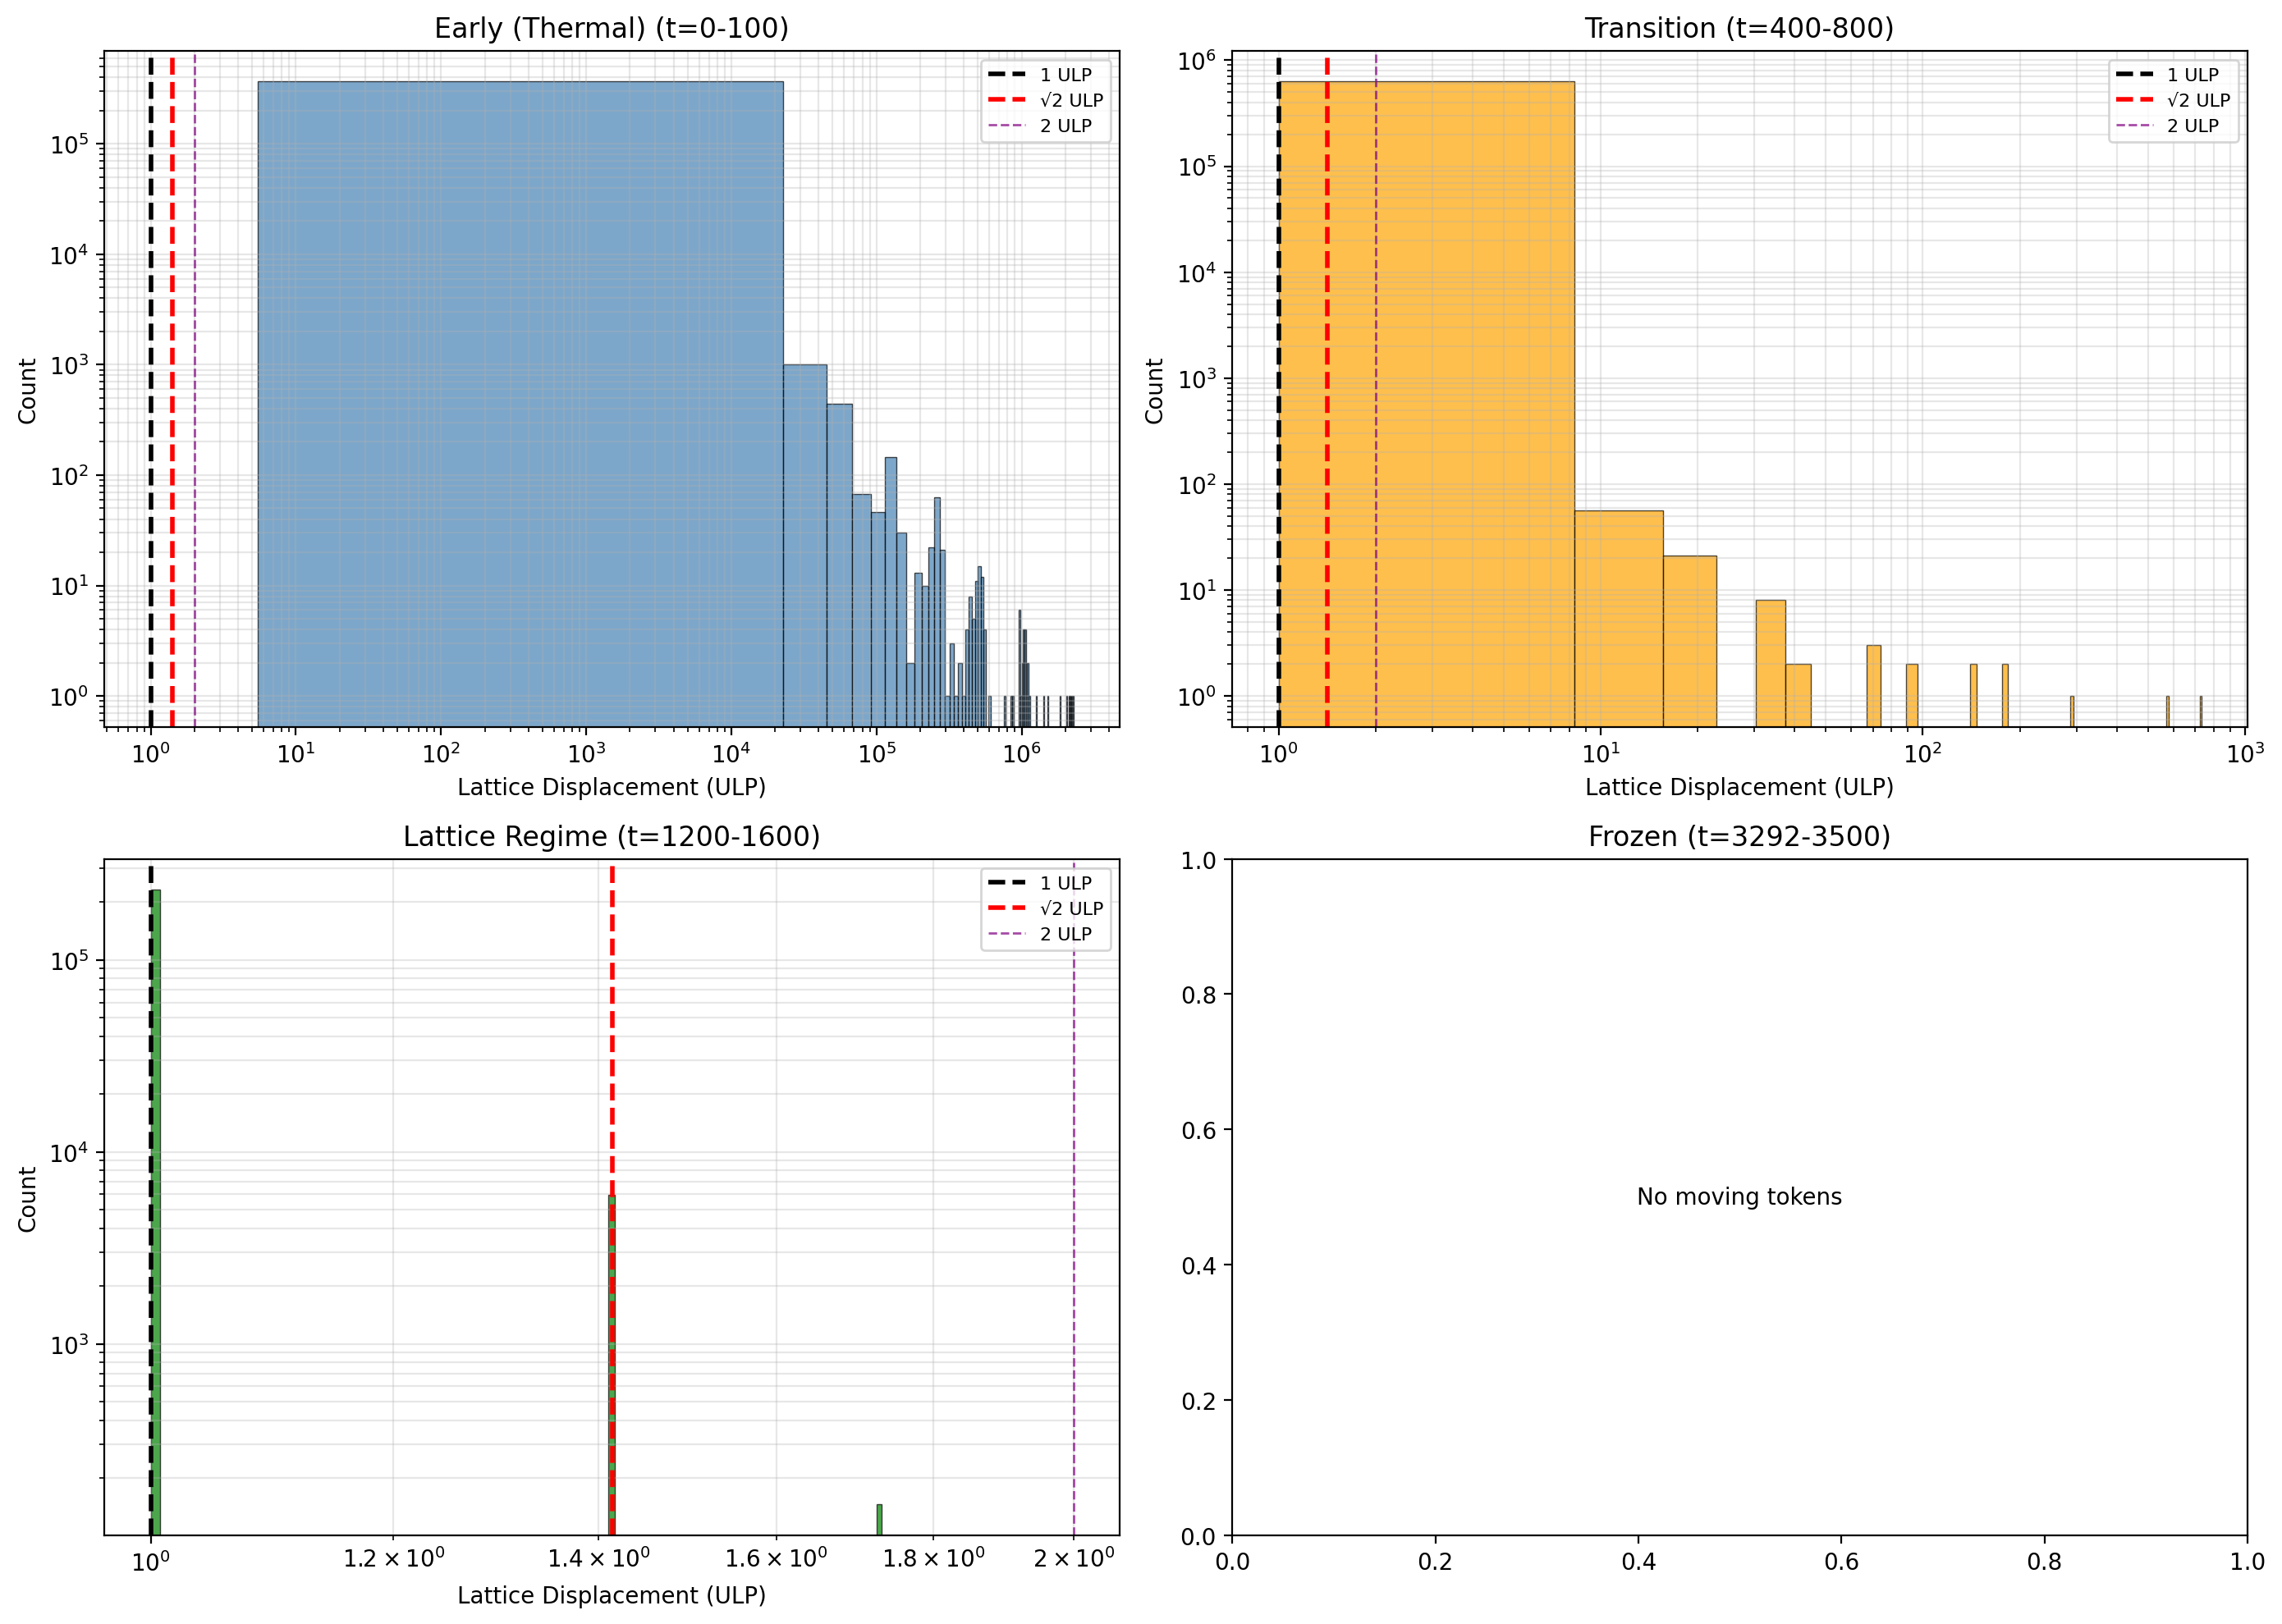


Interpretation: Do we see quantization peaks at 1, √2, √3, 2, ... ULP?
  Early: Continuous distribution (no quantization)
  Transition: Bimodal? (large hops + lattice hops)
  Lattice: Peaks at discrete values
  Frozen: Everything at zero (not shown in log scale)


In [22]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=DPI)
axes = axes.flatten()

windows = [
    (EARLY_WINDOW, "Early (Thermal)", 'steelblue'),
    (MIDDLE_WINDOW, "Transition", 'orange'),
    (LATE_WINDOW, "Lattice Regime", 'green'),
    (FROZEN_WINDOW, "Frozen", 'gray')
]

for ax, (window, label, color) in zip(axes, windows):
    t_start, t_end = window
    
    # Get all L2 norms in this window
    data = dW_lattice_L2[t_start:t_end].flatten().numpy()
    
    # Filter out zeros and infinities for log scale
    data_nonzero = data[data > 0]
    data_nonzero = data_nonzero[np.isfinite(data_nonzero)]
    
    if len(data_nonzero) > 0:
        # Histogram
        ax.hist(data_nonzero, bins=100, color=color, alpha=0.7, edgecolor='black', linewidth=0.5)
        
        # Mark special values
        ax.axvline(1, color='black', linestyle='--', linewidth=2, label='1 ULP')
        ax.axvline(np.sqrt(2), color='red', linestyle='--', linewidth=2, label='√2 ULP')
        ax.axvline(2, color='purple', linestyle='--', linewidth=1, alpha=0.7, label='2 ULP')
        
        ax.set_xlabel('Lattice Displacement (ULP)')
        ax.set_ylabel('Count')
        ax.set_title(f'{label} (t={t_start}-{t_end})')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3, which='both')
    else:
        ax.text(0.5, 0.5, 'No moving tokens', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{label} (t={t_start}-{t_end})')

plt.tight_layout()
plt.show()

print("\nInterpretation: Do we see quantization peaks at 1, √2, √3, 2, ... ULP?")
print("  Early: Continuous distribution (no quantization)")
print("  Transition: Bimodal? (large hops + lattice hops)")
print("  Lattice: Peaks at discrete values")
print("  Frozen: Everything at zero (not shown in log scale)")

## Plot 3: Sparsity (How Many Dimensions Move?)

Computing sparsity (number of moving dimensions per token)...



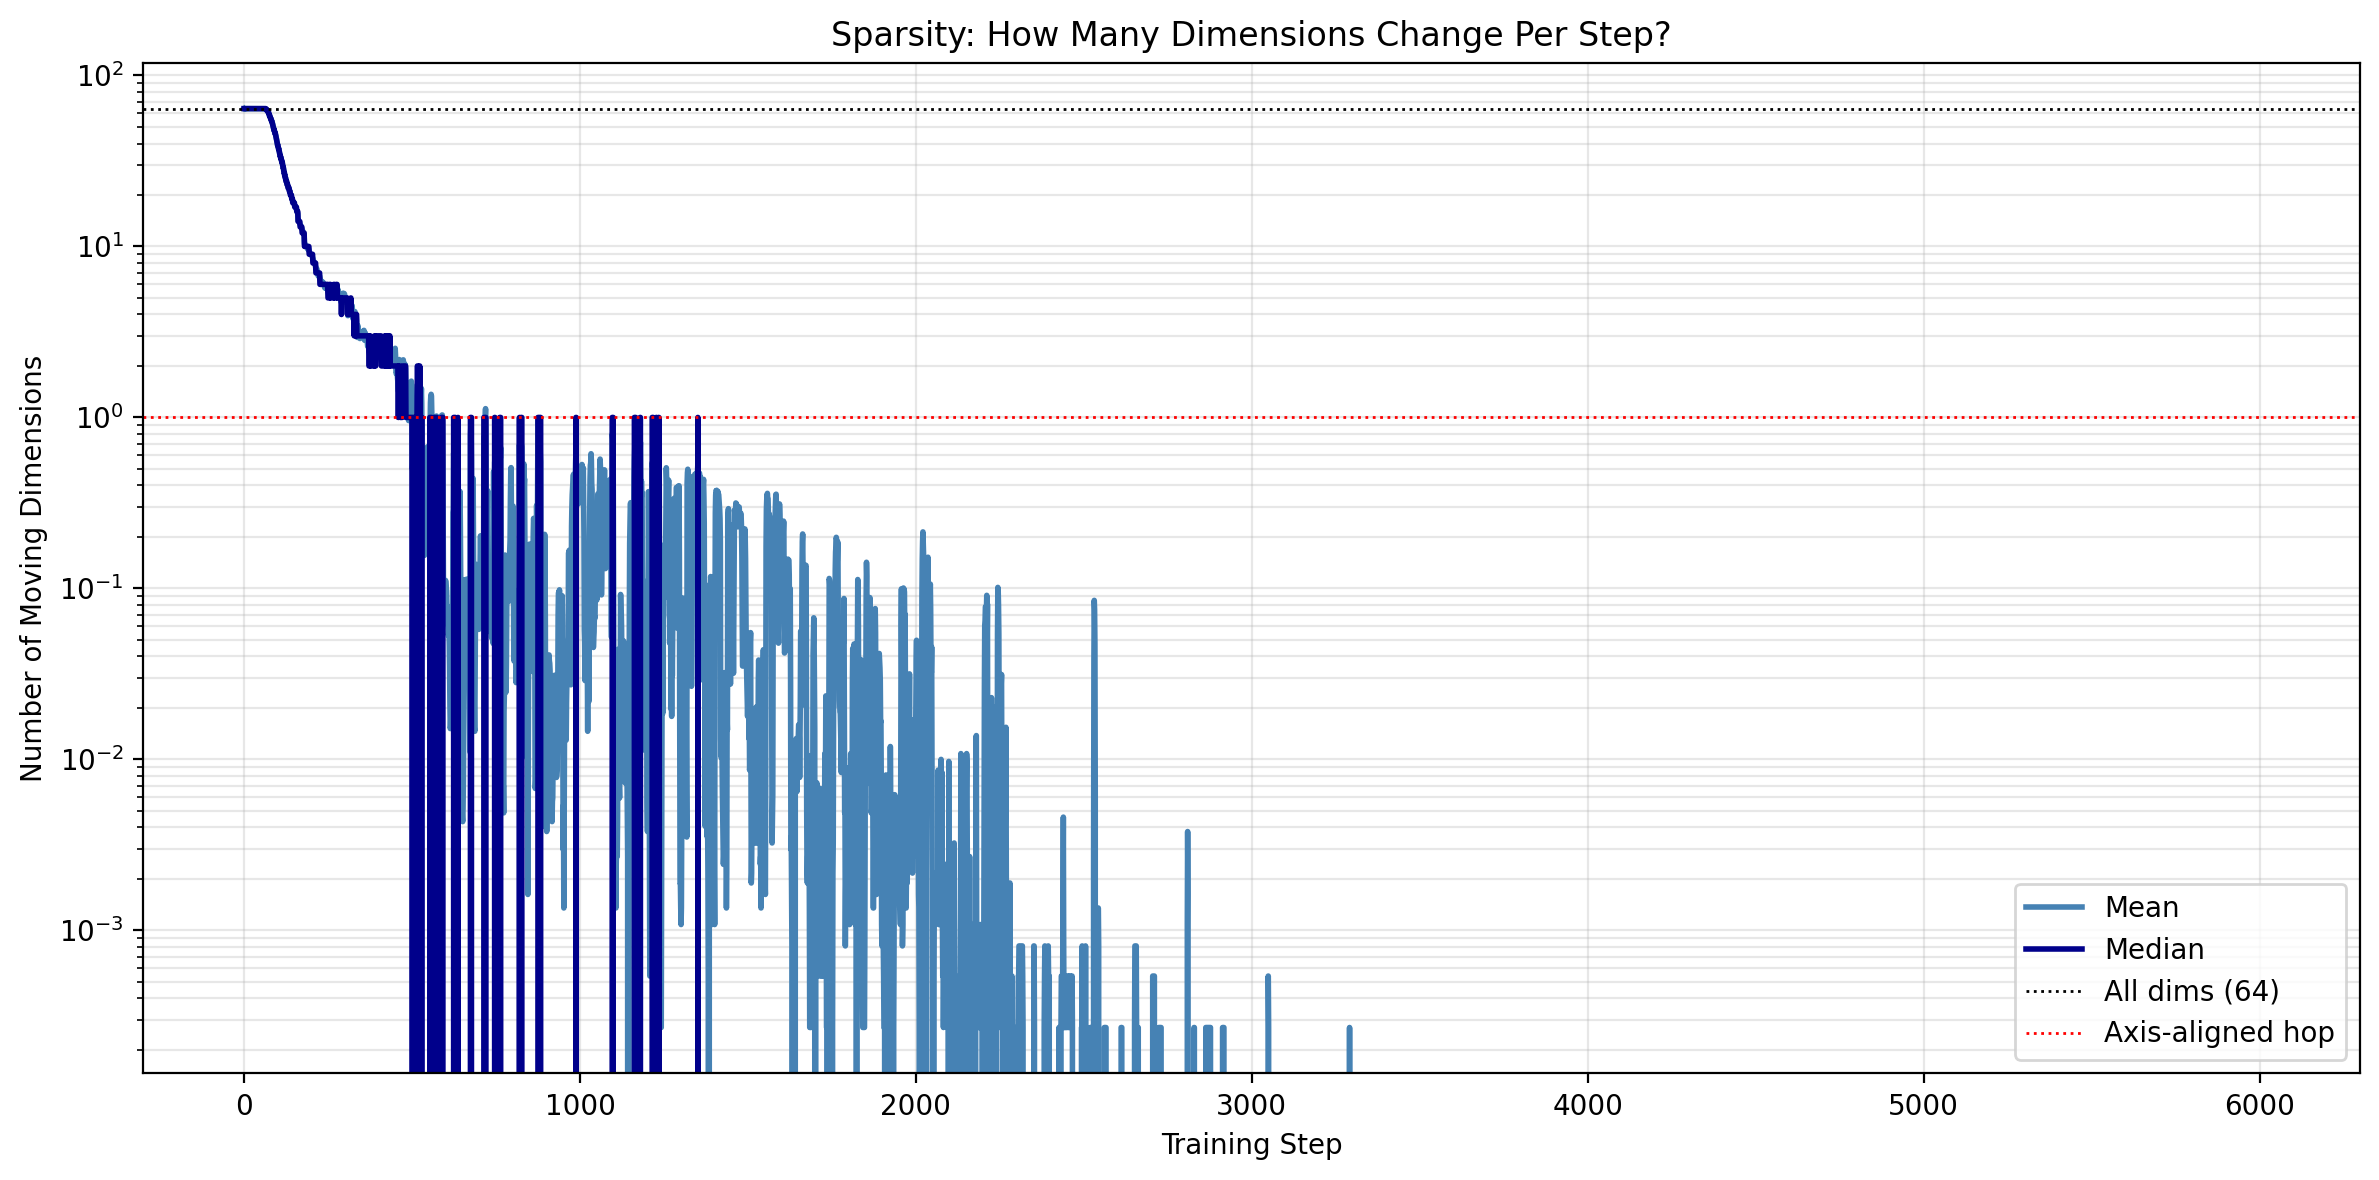


Interpretation: Are hops axis-aligned (1-2 dims) or diagonal (many dims)?
  Many dims → continuous/thermal motion
  Few dims → lattice hops become axis-aligned


In [23]:
print("Computing sparsity (number of moving dimensions per token)...\n")

# Count nonzero coordinates per token
n_moving_dims = (dW_lattice.abs() > 1e-6).sum(dim=2).float()  # (6000, 3699)

# Statistics over time
mean_moving_dims = n_moving_dims.mean(dim=1).numpy()
median_moving_dims = n_moving_dims.median(dim=1)[0].numpy()

fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

ax.plot(mean_moving_dims, linewidth=2, color='steelblue', label='Mean')
ax.plot(median_moving_dims, linewidth=2, color='darkblue', label='Median')
ax.axhline(64, color='black', linestyle=':', linewidth=1, label='All dims (64)')
ax.axhline(1, color='red', linestyle=':', linewidth=1, label='Axis-aligned hop')

ax.set_xlabel('Training Step')
ax.set_ylabel('Number of Moving Dimensions')
ax.set_title('Sparsity: How Many Dimensions Change Per Step?')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("\nInterpretation: Are hops axis-aligned (1-2 dims) or diagonal (many dims)?")
print("  Many dims → continuous/thermal motion")
print("  Few dims → lattice hops become axis-aligned")

## Plot 4: L∞/L2 Ratio (Axis Alignment)

Computing L∞/L2 ratio (axis alignment metric)...



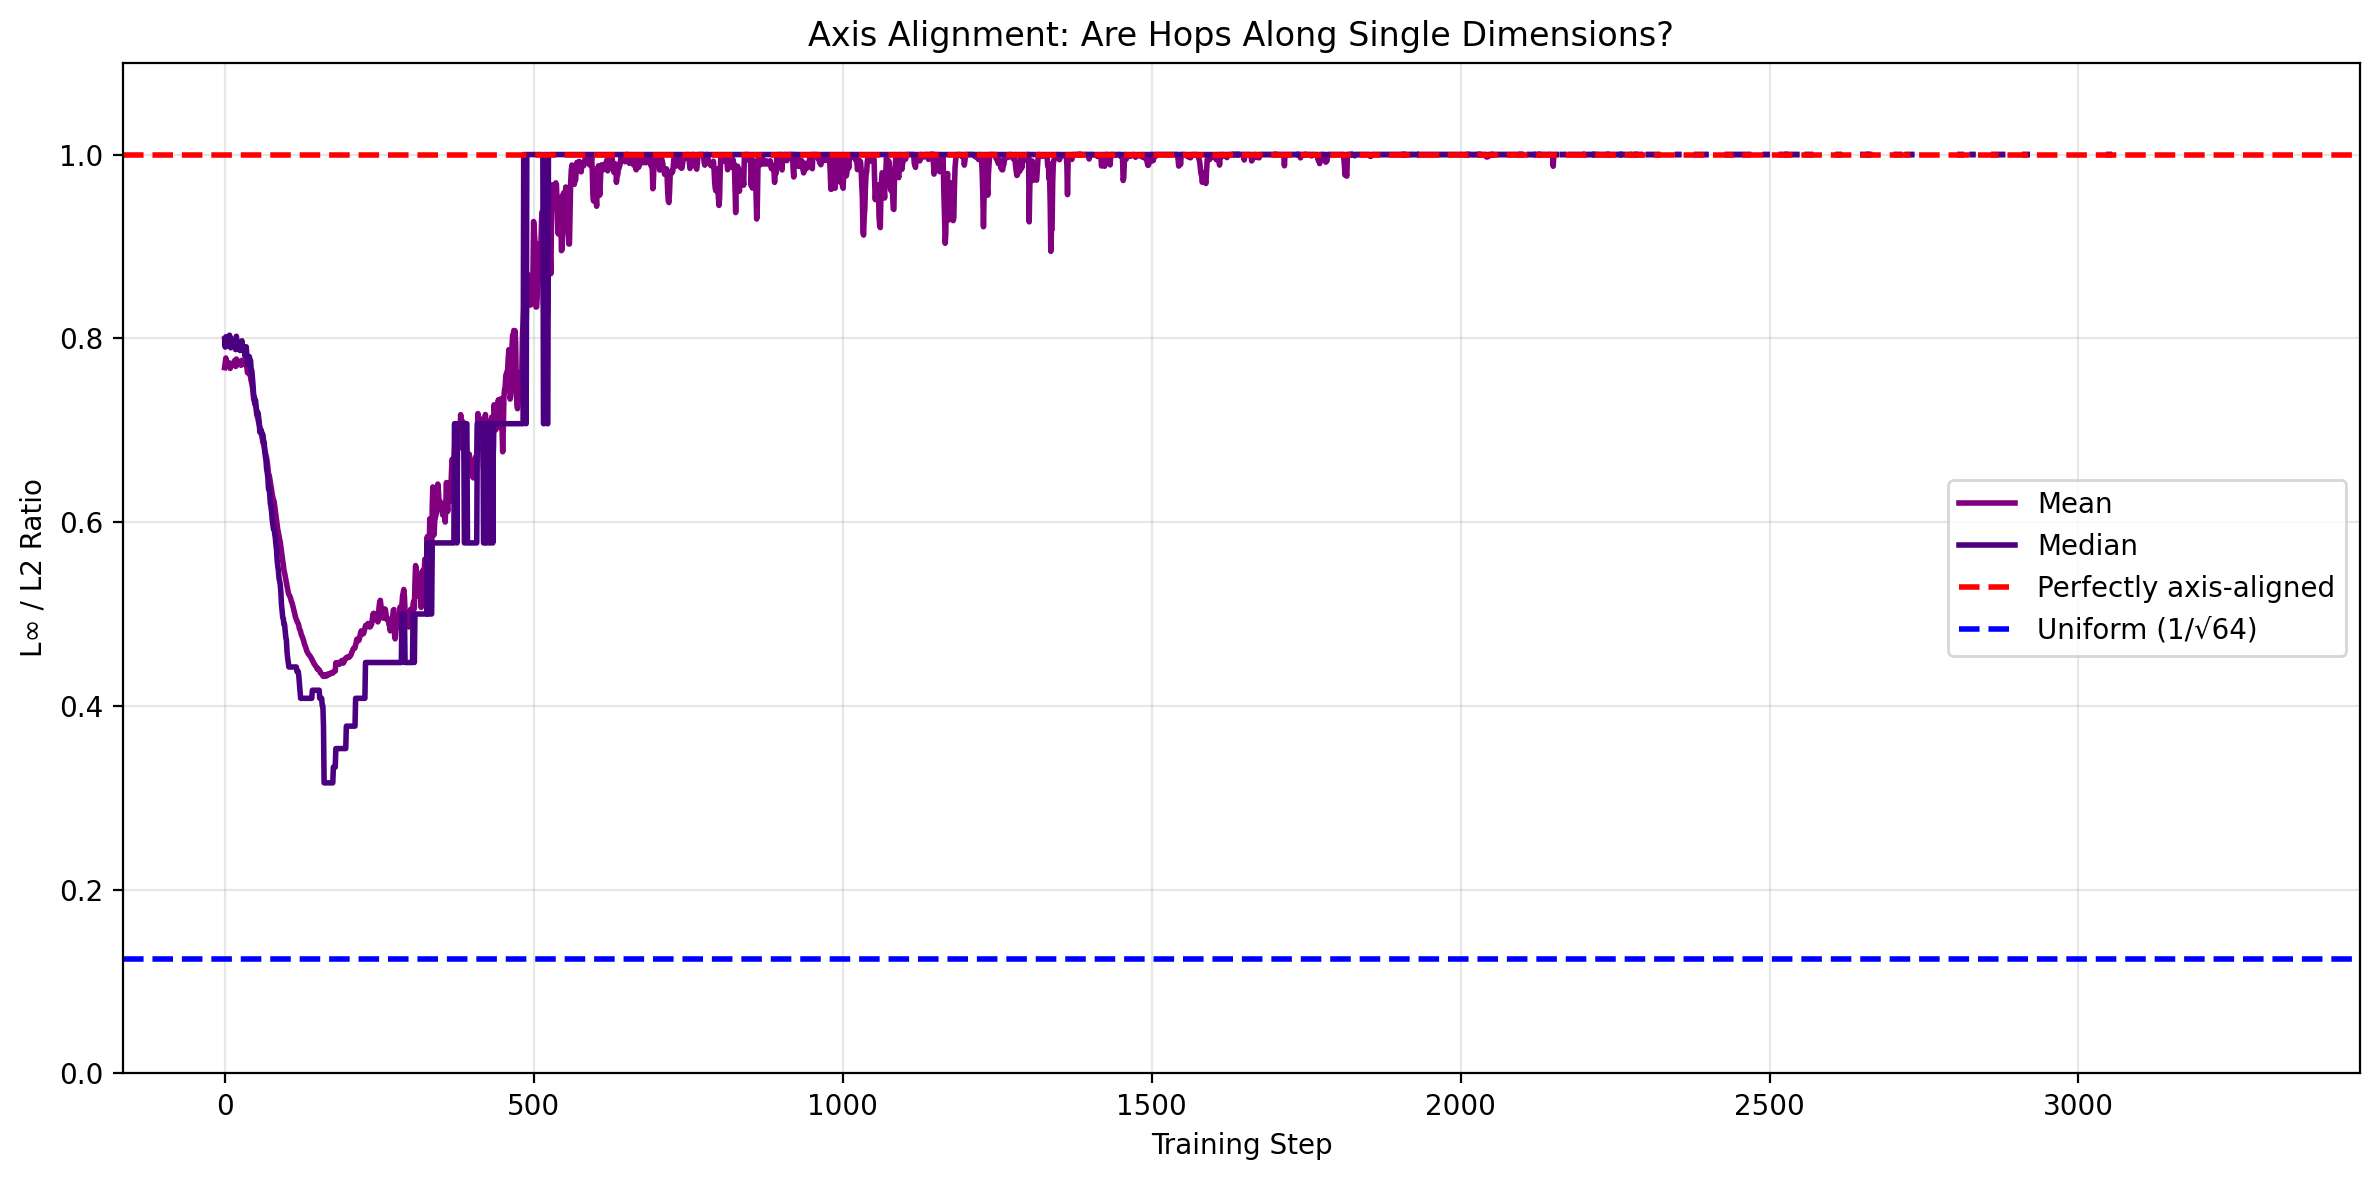


Interpretation:
  Ratio → 1.0: Motion becomes axis-aligned (lattice hops)
  Ratio → 1/√64: Motion uniform across dimensions (thermal)


In [24]:
print("Computing L∞/L2 ratio (axis alignment metric)...\n")

# Ratio: 1.0 = perfectly axis-aligned, 1/√64 ≈ 0.125 = uniform across all dims
ratio = dW_lattice_Linf / (dW_lattice_L2 + 1e-10)

# Only consider moving tokens
moving = dW_lattice_L2 > 1e-6
ratio[~moving] = float('nan')

# Statistics
mean_ratio = torch.nanmean(ratio, dim=1).numpy()
median_ratio = torch.nanmedian(ratio, dim=1)[0].numpy()

fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

ax.plot(mean_ratio, linewidth=2, color='purple', label='Mean')
ax.plot(median_ratio, linewidth=2, color='indigo', label='Median')
ax.axhline(1.0, color='red', linestyle='--', linewidth=2, label='Perfectly axis-aligned')
ax.axhline(1/np.sqrt(64), color='blue', linestyle='--', linewidth=2, label='Uniform (1/√64)')

ax.set_xlabel('Training Step')
ax.set_ylabel('L∞ / L2 Ratio')
ax.set_title('Axis Alignment: Are Hops Along Single Dimensions?')
ax.set_ylim([0, 1.1])
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  Ratio → 1.0: Motion becomes axis-aligned (lattice hops)")
print("  Ratio → 1/√64: Motion uniform across dimensions (thermal)")

## Summary Statistics

In [25]:
print("\n" + "="*80)
print("LATTICE SPACE ANALYSIS SUMMARY")
print("="*80 + "\n")

print("GLOBAL STATISTICS:")
print("-" * 40)
print(f"Total coordinates: {n_total_coords:,}")
print(f"Frozen coordinates: {n_frozen_coords:,} ({frozen_fraction:.1%})")

print("\nLATTICE DISPLACEMENT STATISTICS (L2 norm in ULP):")
print("-" * 40)

for window, label, _ in windows:
    t_start, t_end = window
    data = dW_lattice_L2[t_start:t_end][dW_lattice_L2[t_start:t_end] > 0]
    
    if len(data) > 0:
        print(f"\n{label} (t={t_start}-{t_end}):")
        print(f"  Mean:   {data.mean().item():8.2f} ULP")
        print(f"  Median: {data.median().item():8.2f} ULP")
        print(f"  90th:   {data.quantile(0.9).item():8.2f} ULP")
        print(f"  Max:    {data.max().item():8.2f} ULP")
        
        # Fraction in lattice regime (< 10 ULP)
        in_lattice = (data < 10).sum().item() / len(data)
        print(f"  Fraction < 10 ULP: {in_lattice:.1%}")

print("\n" + "="*80)
print("✓ Lattice space analysis complete.")
print("="*80)


LATTICE SPACE ANALYSIS SUMMARY

GLOBAL STATISTICS:
----------------------------------------
Total coordinates: 1,420,416,000
Frozen coordinates: 1,385,749,994 (97.6%)

LATTICE DISPLACEMENT STATISTICS (L2 norm in ULP):
----------------------------------------

Early (Thermal) (t=0-100):
  Mean:        inf ULP
  Median:    84.94 ULP
  90th:    1155.39 ULP
  Max:         inf ULP
  Fraction < 10 ULP: 9.0%

Transition (t=400-800):
  Mean:       1.29 ULP
  Median:     1.00 ULP
  90th:       1.73 ULP
  Max:      732.00 ULP
  Fraction < 10 ULP: 100.0%

Lattice Regime (t=1200-1600):
  Mean:       1.01 ULP
  Median:     1.00 ULP
  90th:       1.00 ULP
  Max:        1.73 ULP
  Fraction < 10 ULP: 100.0%

✓ Lattice space analysis complete.
